 ## HW4 - EuroSAT Land Use and Land Cover Classification using Deep Learning
 
In this homework your task is to implement deep learning models to solve a typical problem in satellite imaging  using a benchmark dataset. The homework was designed to make you work on increasingly more complex models. We hope that the homework will be very helpful to improve your skills and knowledge in deep learning!


### S1:

- Visit the EuroSAT data description page and download the data: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

- Convert each RGB image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)


In [1]:
#!pip install tensorflow_datasets

In [6]:
## import packages
import os
import numpy as np 
import pandas as pd 
import math
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import PIL
import PIL.Image
import rasterio
import cv2

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
# import tensorflow_datasets as tfds
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten
from keras.layers import Input, BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical


from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2, l1
from tensorflow import math

In [2]:
# Garbage Collector - running into Colab allocated RAM issues
# Code from https://stackoverflow.com/questions/61188185/how-to-free-memory-in-colab
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [4]:
## Run from Colab
# from google.colab import drive

# drive.mount('/content/drive')

# path = "/content/drive/MyDrive/Grad School/Penn_MUSA/Spring2022/650_RemoteSensing/Homework/HW4/Data/EuroSAT_RGB/"

In [5]:
# Local run
path = "./Data/EuroSAT_RGB/"

In [6]:
imgs = []
labels = os.listdir(path)

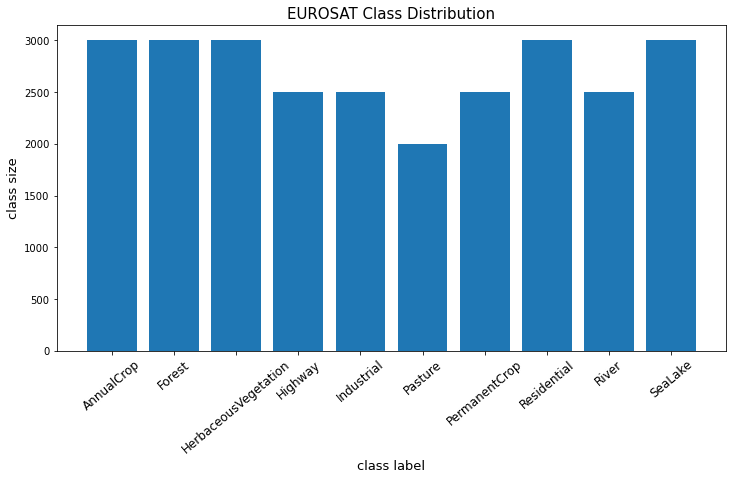

In [7]:
# plot class distributions of whole dataset
counts = {}

for l in labels:
    counts[l] = len(os.listdir(os.path.join(path, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [8]:
## Get all of the class names from their directory names
classNames = os.listdir(path)

## Find the total number of classes
numClass = len(classNames)

## Identify the number of images in each class by reading the number of files
## in each class directory
lenClass = np.zeros(numClass)
for i in np.arange(0, numClass):
  lenClass[i] = len(os.listdir(path + '/' + classNames[i]))
print(classNames)
print(lenClass)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
[3000. 3000. 3000. 2500. 2500. 2000. 2500. 3000. 2500. 3000.]


(64, 64, 3)

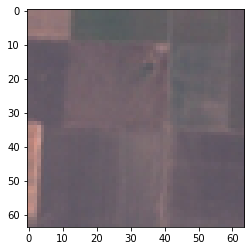

In [10]:
## Find the shape of one image so we can load the rest
imgSel = path + '/' + classNames[0] + '/' + os.listdir(path + '/' + classNames[0])[0]
img = PIL.Image.open(imgSel, 'r')
plt.imshow(np.asarray(img))
np.asarray(img).shape

In [11]:
## numImg is the total number of images in the dataset
numImg  = int(lenClass.sum())

## numPixels is the number of pixels in each image
numPixels = np.asarray(img).shape # 64 x 64 x 3 px in rgb img
numGrayPixels = np.prod(np.asarray(img.convert('L')).shape) # 4096 px in grayscale

In [12]:
## Initialize arrays for Grayscale imgs
X = np.zeros([numImg, numGrayPixels])
y = np.zeros(numImg)

In [13]:
## Read images vectors into X array
## Read image labels into y array

imgInd=0
for i in np.arange(0, numClass):
  className = classNames[i]
  for imgName in os.listdir(path + '/' + className):
    img = PIL.Image.open(path + '/' + className + '/' + imgName, 'r').convert('L') # convert imgs to grayscale
    imgVec = np.asarray(img).flatten() #flatten img to np array, rather than img matrix

    # Append to grayscale dataset
    X[imgInd,:] = imgVec
    y[imgInd] = i

    imgInd += 1

# print(X.shape)
# print(y.shape)

In [14]:
# Convert class vectors to binary class matrices
y = to_categorical(y, numClass)

In [15]:
# np.array(np.unique(y, return_counts=True)).T

# # change them to integers in alphabetical order
# label_Dict = dict(zip(np.unique(y), classNames))
# print(label_Dict)
# np.array(np.unique(y, return_counts=True)).T

array([[0.00e+00, 2.43e+05],
       [1.00e+00, 2.70e+04]])

In [15]:
## Create Train/Test split 50:50 split
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, stratify = y, random_state=42)

### S2:

- Implement a first deep learning model (M.1) using a fully connected network with a single fully connected layer (i.e: input layer + fully connected layer as the output layer). 

Q2.1: Calculate classification accuracy on the test data.  

In [16]:
## Declare modeling parameters
opt = Adam(learning_rate=0.001)
NUM_EPOCH = 150
B_SIZE = 64

In [17]:
m1 = Sequential()
# m1.add(Input(shape = (4096,)))
m1.add(Dense(10, input_shape=(4096,), activation='softmax'))

plot_model(m1, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [18]:
## Compile the model
m1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [19]:
## Train the model
md1_tr = m1.fit(X1, y1, batch_size=B_SIZE, epochs=NUM_EPOCH, shuffle=True, validation_data=(X2, y2))

Epoch 1/150
211/211 [==============================] - 2s 8ms/step - loss: 2383.4033 - accuracy: 0.1147 - val_loss: 1857.9191 - val_accuracy: 0.1454
Epoch 2/150
211/211 [==============================] - 2s 9ms/step - loss: 1729.2267 - accuracy: 0.1286 - val_loss: 1593.1539 - val_accuracy: 0.1116
Epoch 3/150
211/211 [==============================] - 1s 7ms/step - loss: 1433.1027 - accuracy: 0.1250 - val_loss: 1461.6816 - val_accuracy: 0.0831
Epoch 4/150
211/211 [==============================] - 3s 13ms/step - loss: 1623.9734 - accuracy: 0.1324 - val_loss: 1665.2815 - val_accuracy: 0.1539
Epoch 5/150
211/211 [==============================] - 2s 10ms/step - loss: 1527.4631 - accuracy: 0.1364 - val_loss: 1823.8837 - val_accuracy: 0.1450
Epoch 6/150
211/211 [==============================] - 3s 13ms/step - loss: 1440.5717 - accuracy: 0.1319 - val_loss: 2665.9519 - val_accuracy: 0.09260s - loss: 1501.8522 - accu
Epoch 7/150
211/211 [==============================] - 2s 10ms/step - loss: 

In [20]:
score = m1.evaluate(X2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 937.069580078125
Test accuracy: 0.13148148357868195


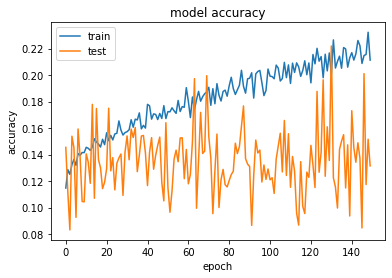

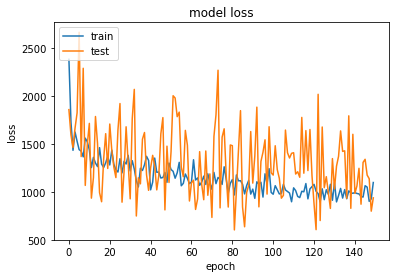

In [21]:
plt.plot(md1_tr.history['accuracy'])
plt.plot(md1_tr.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(md1_tr.history['loss'])
plt.plot(md1_tr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# y_test_true_tmp = np.argmax(y2, axis = 1)
# label_count = np.unique(y_test_true_tmp, return_counts = True)[1]

In [23]:
# Define functions for evaluating model accuracy by class and overall

# def eval_model_by_class(model, test_set):
#   y_test_pred_tmp = model.predict(test_set)

#   y_test_true = [classNames[x] for x in y_test_true_tmp]
#   y_test_pred = [classNames[x] for x in y_test_pred_tmp]

#   pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
#   pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
#   pred_df = pred_df.groupby(['y_true']).sum().reset_index()
#   pred_df['label_count'] = label_count
#   pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
#   pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
#   pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
#   pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

#   return(pred_df)

# def find_wrong_preds(model, test_set):
#   y_test_pred_tmp = model.predict(test_set)

#   y_test_true = [classNames[x] for x in y_test_true_tmp]
#   y_test_pred = [classNames[x] for x in y_test_pred_tmp]

#   pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
#   pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
#   # pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
#   pred_df = pred_df.sort_values('y_true')

#   return(pred_df)

In [24]:
# m1_pred_df = eval_model_by_class(m1, X1)
# m1_pred_df

### S3:

- Implement a second deep learning model (M.2) adding an additional fully connected hidden layer (with an arbitrary number of nodes) to the previous model. 

Q3.1: Calculate classification accuracy on the test data.  

In [25]:
m2 = Sequential()
m2.add(Input(shape = (4096,)))
m2.add(Dense(2048, activation='relu'))
m2.add(Dense(10, activation='softmax'))

plot_model(m2, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [26]:
## Compile the model
m2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Train the model
md2_tr = m2.fit(X1, y1, batch_size=B_SIZE, epochs=NUM_EPOCH, shuffle=True, validation_data=(X2, y2))

Epoch 1/150
211/211 [==============================] - 9s 42ms/step - loss: 11863.5400 - accuracy: 0.1081 - val_loss: 2.3539 - val_accuracy: 0.1112
Epoch 2/150
211/211 [==============================] - 8s 36ms/step - loss: 28.9628 - accuracy: 0.1115 - val_loss: 2.3153 - val_accuracy: 0.1112
Epoch 3/150
211/211 [==============================] - 7s 35ms/step - loss: 2.3037 - accuracy: 0.1086 - val_loss: 2.2972 - val_accuracy: 0.1113
Epoch 4/150
211/211 [==============================] - 7s 35ms/step - loss: 2.2959 - accuracy: 0.1079 - val_loss: 2.2960 - val_accuracy: 0.1113
Epoch 5/150
211/211 [==============================] - 8s 37ms/step - loss: 2.2957 - accuracy: 0.1081 - val_loss: 2.2959 - val_accuracy: 0.1113
Epoch 6/150
211/211 [==============================] - 8s 36ms/step - loss: 2.2955 - accuracy: 0.1087 - val_loss: 2.2962 - val_accuracy: 0.1115
Epoch 7/150
211/211 [==============================] - 8s 36ms/step - loss: 2.2958 - accuracy: 0.1092 - val_loss: 2.2961 - val_accu

In [27]:
score = m2.evaluate(X2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.2959954738616943
Test accuracy: 0.11140740662813187


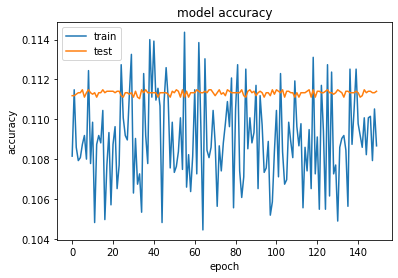

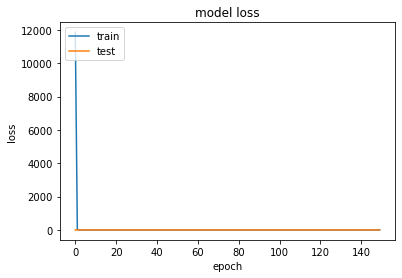

In [28]:
plt.plot(md2_tr.history['accuracy'])
plt.plot(md2_tr.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(md2_tr.history['loss'])
plt.plot(md2_tr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
# m2_pred_df = eval_model_by_class(m2, X1)
# m2_pred_df

### S4:

- Implement a third deep learning model (M.3) adding two additional fully connected hidden layers (with arbitrary number of nodes) for a total of four, as well as drop-out layers to the previous model. 

Q4.1: Calculate classification accuracy on the test data.

Q4.2: Compare against previous models. Which model was the "best"? Why?

In [30]:
m3 = Sequential()
m3.add(Dense(1024, input_shape=(4096,), activation='relu'))
m3.add(Dropout(0.2))
m3.add(Dense(256, activation='relu'))
m3.add(Dropout(0.2))
m3.add(Dense(64, activation='relu'))
m3.add(Dropout(0.2))
m3.add(Dense(10, activation='softmax'))

plot_model(m3, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [31]:
## Compile the model
m3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Train the model
md3_tr = m3.fit(X1, y1, batch_size=B_SIZE, epochs=NUM_EPOCH, shuffle=True, validation_data=(X2, y2))

Epoch 1/150
211/211 [==============================] - 5s 22ms/step - loss: 1446.5183 - accuracy: 0.1126 - val_loss: 2.2988 - val_accuracy: 0.1111
Epoch 2/150
211/211 [==============================] - 4s 20ms/step - loss: 2.2965 - accuracy: 0.1136 - val_loss: 2.2966 - val_accuracy: 0.1111
Epoch 3/150
211/211 [==============================] - 4s 20ms/step - loss: 2.2965 - accuracy: 0.1105 - val_loss: 2.2958 - val_accuracy: 0.1111
Epoch 4/150
211/211 [==============================] - 4s 20ms/step - loss: 2.2964 - accuracy: 0.1121 - val_loss: 2.2953 - val_accuracy: 0.1111
Epoch 5/150
211/211 [==============================] - 4s 20ms/step - loss: 2.2964 - accuracy: 0.1087 - val_loss: 2.2955 - val_accuracy: 0.1111
Epoch 6/150
211/211 [==============================] - 4s 19ms/step - loss: 2.2959 - accuracy: 0.1113 - val_loss: 2.2953 - val_accuracy: 0.1111
Epoch 7/150
211/211 [==============================] - 4s 20ms/step - loss: 2.2962 - accuracy: 0.1074 - val_loss: 2.2955 - val_accura

In [32]:
score = m3.evaluate(X2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.2960708141326904
Test accuracy: 0.1111111119389534


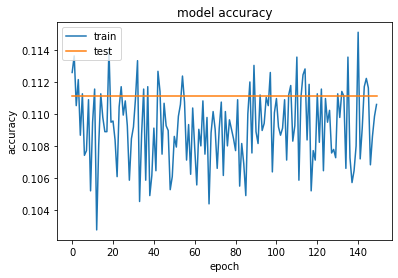

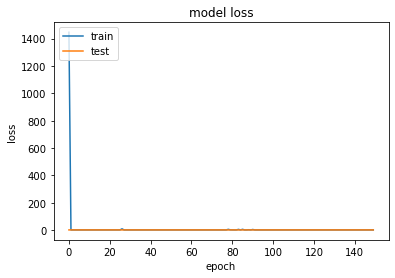

In [33]:
plt.plot(md3_tr.history['accuracy'])
plt.plot(md3_tr.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(md3_tr.history['loss'])
plt.plot(md3_tr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# m3_pred_df = eval_model_by_class(m3, X1)
# m3_pred_df

### S5:

- Take the original RGB images and do not vectorize them. Use these images as the data input for the following models (M.4 and M.5).
- Implement a fourth CNN model (M.4) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

Q5.1: Calculate classification accuracy on the test data.

Q5.2: Compare against previous models. Which model was the "best"? Why?

In [35]:
# Clear memory to make space for next steps
del X, y, X1, X2, y1, y2, m1, m2, m3, md1_tr, md2_tr, md3_tr

In [36]:
## Initialize arrays for RGB dataset
X_RGB = np.zeros([numImg, 64, 64, 3])
y = np.zeros(numImg)

## Read images vectors into X array
## Read image labels into y array

imgInd=0
for i in np.arange(0, numClass):
  className = classNames[i]
  for imgName in os.listdir(path + '/' + className):
    img = PIL.Image.open(path + '/' + className + '/' + imgName, 'r')

    # Append to RGB dataset
    X_RGB[imgInd,:] = img
    y[imgInd] = i

    imgInd += 1

# print(X_RGB.shape)
# print(y.shape)

In [37]:
# Convert class vectors to binary class matrices
y = to_categorical(y, numClass)

## Create Train/Test split 50:50 split
from sklearn.model_selection import train_test_split
X_RGB_1, X_RGB_2, y1, y2 = train_test_split(X_RGB, y, test_size=0.5, stratify = y, random_state=42)

print(X_RGB_1.shape)
print(X_RGB_2.shape)

(13500, 64, 64, 3)
(13500, 64, 64, 3)


In [38]:
# Create DL model for RGB matrices
m4 = Sequential()
m4.add(Conv2D(32, kernel_size=(4, 4),strides=(2,2), padding='same', input_shape=(64,64,3), activation='relu'))
m4.add(MaxPooling2D(pool_size=(2, 2))) #5x5
m4.add(Dropout(0.25))

m4.add(Flatten())
m4.add(Dense(10, activation='relu'))
    
plot_model(m4, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [39]:
## Compile the model
m4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Train the model
md4_tr = m4.fit(X_RGB_1, y1, batch_size=B_SIZE, epochs=NUM_EPOCH, shuffle=True, validation_data=(X_RGB_2, y2))

Epoch 1/150
211/211 [==============================] - 4s 17ms/step - loss: nan - accuracy: 0.1492 - val_loss: nan - val_accuracy: 0.1111
Epoch 2/150
211/211 [==============================] - 4s 18ms/step - loss: nan - accuracy: 0.1111 - val_loss: nan - val_accuracy: 0.1111
Epoch 3/150
211/211 [==============================] - 4s 18ms/step - loss: nan - accuracy: 0.1111 - val_loss: nan - val_accuracy: 0.1111
Epoch 4/150
211/211 [==============================] - 4s 17ms/step - loss: nan - accuracy: 0.1111 - val_loss: nan - val_accuracy: 0.1111
Epoch 5/150
211/211 [==============================] - 4s 18ms/step - loss: nan - accuracy: 0.1111 - val_loss: nan - val_accuracy: 0.1111
Epoch 6/150
211/211 [==============================] - 3s 16ms/step - loss: nan - accuracy: 0.1111 - val_loss: nan - val_accuracy: 0.1111
Epoch 7/150
211/211 [==============================] - 3s 16ms/step - loss: nan - accuracy: 0.1111 - val_loss: nan - val_accuracy: 0.1111
Epoch 8/150
211/211 [=============

In [ ]:
score = m4.evaluate(X_RGB_2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
plt.plot(md4_tr.history['accuracy'])
plt.plot(md4_tr.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(md4_tr.history['loss'])
plt.plot(md4_tr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# m4_pred_df = eval_model_by_class(m4, X1)
# m4_pred_df

### S6:

- Using RGB images from S5, implement a fifth deep learning model (M.5) targeting accuracy that will outperform all previous models. You are free to use any tools and techniques, as well as pre-trained models for transfer learning. 

Q6.1: Describe the model you built, and why you chose it.

Q6.2: Calculate classification accuracy on the test data.

Q6.3: Compare against previous models. Which model was the "best"? Why?

Q6.4: What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.

In [ ]:
m5 = Sequential()

m5.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3), activation='relu'))
m5.add(MaxPooling2D(pool_size=(2, 2))) #40x40
m5.add(Dropout(0.25))

m5.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
m5.add(MaxPooling2D(pool_size=(2, 2))) #20x20
m5.add(Dropout(0.25))

m5.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
m5.add(MaxPooling2D(pool_size=(2, 2))) #10x10
m5.add(Dropout(0.25))

m5.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
m5.add(MaxPooling2D(pool_size=(2, 2))) #5x5
m5.add(Dropout(0.25))

m5.add(Flatten())
m5.add(Dense(512, activation='relu'))
m5.add(Dropout(0.5))

m5.add(Dense(10, activation='softmax'))

plot_model(m5, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
## Compile the model
m5.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Train the model
md5_tr = m5.fit(X_RGB_1, y1, batch_size=B_SIZE, epochs=NUM_EPOCH, shuffle=True, validation_data=(X_RGB_2, y2))

Epoch 1/5
211/211 [==============================] - 22s 99ms/step - loss: 2.2961 - accuracy: 0.1078 - val_loss: 2.2950 - val_accuracy: 0.1111
Epoch 2/5
211/211 [==============================] - 21s 100ms/step - loss: 2.2958 - accuracy: 0.1113 - val_loss: 2.2956 - val_accuracy: 0.1111
Epoch 3/5
211/211 [==============================] - 21s 101ms/step - loss: 2.2957 - accuracy: 0.1092 - val_loss: 2.2960 - val_accuracy: 0.1111
Epoch 4/5
211/211 [==============================] - 21s 101ms/step - loss: 2.2960 - accuracy: 0.1115 - val_loss: 2.2956 - val_accuracy: 0.1111
Epoch 5/5
211/211 [==============================] - 21s 99ms/step - loss: 2.2956 - accuracy: 0.1141 - val_loss: 2.2956 - val_accuracy: 0.1111


In [ ]:
score = m5.evaluate(X_RGB_2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.295604944229126
Test accuracy: 0.1111111119389534


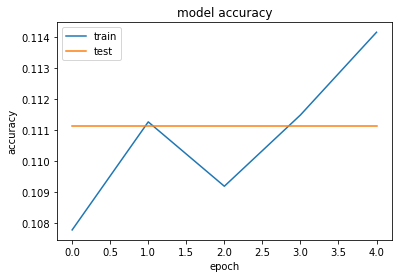

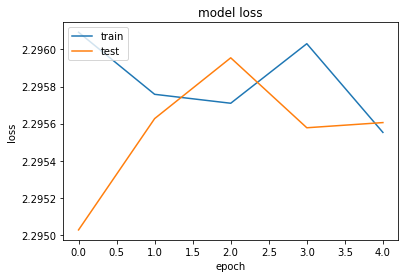

In [ ]:
plt.plot(md5_tr.history['accuracy'])
plt.plot(md5_tr.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(md5_tr.history['loss'])
plt.plot(md5_tr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# m5_pred_df = eval_model_by_class(m5, X1)
# m5_pred_df

In [ ]:
y_pred = m5.predict(X2)
y_pred = np.argmax(y_pred, axis=1)
y_pred = y_pred.astype('int32')
y2 = y2.astype('int32')

In [ ]:
# See https://www.tensorflow.org/tutorials/audio/simple_audio for how to set up confusion mtx
confusion_mtx = tf.math.confunsion_matrix(y2, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=classNames,
            yticklabels=classNames,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


### S7:

- Apply your best model on multispectral images. You may use whichever image channels you wish, so long as you use more than just RGB (although you are not required to use any color channels).

Q7.1: Calculate classification accuracy on the test data.

Q7.2: Compare against results using RGB images.

In [ ]:
# Clear memory to make space for next steps
# del X_RGB, y, X_RGB_1, X_RGB_2, y1, y2, m4, m5, md4_tr, md5_tr

In [ ]:
def normalizeBand(band):
  band_norm = np.interp(band, (band.min(), band.max()), (0, 1))
  return band_norm

In [9]:
# Local run
path = "./Data/EuroSAT_AllBands/"

## Get all of the class names from their directory names
classNames = os.listdir(path)

## Find the total number of classes
numClass = len(classNames)

## Identify the number of images in each class by reading the number of files
## in each class directory
lenClass = np.zeros(numClass)
for i in np.arange(0, numClass):
  lenClass[i] = len(os.listdir(path + '/' + classNames[i]))
print(classNames)
print(lenClass)

## numImg is the total number of images in the dataset
numImg  = int(lenClass.sum())

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
[3000. 3000. 3000. 2500. 2500. 2000. 2500. 3000. 2500. 3000.]


In [22]:
img_MS = np.zeros([numImg, 64, 64, 13], dtype="float32")
labels = np.empty(numImg, dtype = 'S20')

In [23]:
## Read images vectors into X array
## Read image labels into y array

imgInd=0
for i in np.arange(0, numClass):
  className = classNames[i]
  for imgName in os.listdir(path + '/' + className):
    with rasterio.open(path + '/' + className + '/' + imgName, 'r') as img:
      tmp = np.moveaxis(img.read(), 0, 2)
      img_MS[imgInd,:] = normalizeBand(tmp)
      labels[imgInd] = i
      imgInd += 1


In [ ]:
label_names, y_labels = np.unique(labels, return_inverse=True)

label_Dict = dict(zip(np.unique(y_labels), label_names))
num_classes = len(np.array(np.unique(y_labels)))

In [ ]:
shuffled = shuffle(y_labels, random_state = 11)

y_shuffled = y_labels[shuffled]
x_shuffled = img_MS[shuffled]

In [ ]:
#X_train3, X_test3, y_train3, y_test3 = train_test_split(x_shuffled, y_shuffled, stratify = yBal, train_size = 0.5, random_state=42)
X_trainMS, X_testMS, y_trainMS, y_testMS = train_test_split(img_MS, y_labels, stratify = y_labels, train_size = 0.5, random_state=11)

In [ ]:
dshape = X_trainMS.shape[1:]

# convert class vectors to binary class matrices
y_trainMSB = to_categorical(y_trainMS, num_classes)
y_testMSB = to_categorical(y_testMS, num_classes)

y_trainMSB.shape

In [ ]:
m6 = Sequential()

m6.add(Conv2D(32, kernel_size=(4, 4), strides=(2,2), padding = "same", input_shape=dshape, activation='relu'))
m6.add(MaxPooling2D((3,3), padding = 'same'))
m6.add(Dropout(0.2))

m6.add(Flatten())

m6.add(Dense(1024, activation='relu'))
m6.add(Dropout(0.2))

m6.add(Dense(512, activation='relu'))
m6.add(Dropout(0.2))

m6.add(Dense(num_classes, activation='softmax'))


plot_model(m6, show_shapes=True, show_layer_names=True)

In [ ]:
## Compile the model
m6.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Train the model
md6_tr = m6.fit(X_trainMS, y_trainMSB, batch_size=B_SIZE, epochs=NUM_EPOCH, shuffle=True, validation_data=(X_testMS, y_testMSB))

In [ ]:
score = m6.evaluate(X_testMS, y_testMSB, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# !pip install tifffile

In [ ]:
# # from osgeo import gdal, ogr
# import tifffile

# # Identify images in the directory:
# imgs = []
# path = "/content/drive/MyDrive/Grad School/Penn_MUSA/Spring2022/650_RemoteSensing/Homework/HW4/Data/EuroSAT_AllBands/"
# labels = os.listdir(path)

# ## Get all of the class names from their directory names
# classNames = os.listdir(path)

# ## Find the total number of classes
# numClass = len(classNames)

# ## Identify the number of images in each class by reading the number of files
# ## in each class directory
# lenClass = np.zeros(numClass)
# for i in np.arange(0, numClass):
#   lenClass[i] = len(os.listdir(path + '/' + classNames[i]))

# ## Find the shape of one image so we can load the rest
# imgSel = path + '/' + classNames[0] + '/' + os.listdir(path + '/' + classNames[0])[0]
# img = tifffile.imread(imgSel)

# ## numImg is the total number of images in the dataset
# numImg  = int(lenClass.sum())

# ## numPixels is the number of pixels in each image
# numPixels = np.asarray(img).shape # 64 x 64 x 3 px in rgb img

# ## Initialize arrays for RGB dataset
# X_MS = np.zeros([numImg, 64, 64, 13])
# y_MS = np.zeros(numImg)

In [ ]:
# ## Read images vectors into X array
# ## Read image labels into y array

# imgInd=0
# for i in np.arange(0, numClass):
#   className = classNames[i]
#   for imgName in os.listdir(path + '/' + className):
#     img = tifffile.imread(path + '/' + className + '/' + imgName, 'r')

#     X_MS[imgInd,:] = img
#     y_MS[imgInd] = i

#     imgInd = imgInd + 1

# print(X_MS.shape)
# print(y_MS.shape)